In [7]:
import os
import preprocess_subject_data
import model_sa_tcn as md
import numpy as np
import tensorflow.keras.layers as layers
import tensorflow.keras as keras


In [8]:
model_obj = md.ED_TCN_fmap_fuse(
    n_classes=12,
    input_length=256,
    early_fuse_cnn_channels=64,
    tcn_encoder_channels=[64]*4,
    tcn_decoder_channels=[64]*4,
    tcn_encoder_maxpool_size=[2]*4,
    tcn_decoder_upsample_size=[2, 2, 2, 2],
    early_fuse_conv_kernel_size=3,
    before_encode_pool_size=2,
    tcn_kernel_size=5,
    tcn_drop_rate=0.3,
    use_spatial_drop=True,
    drop_rate_before_midfc=0.5,
    drop_rate_before_fcclassifier=0.5,
    use_init_batch_norm=True,
)

In [9]:
def create_model(learning_rate=0.001):
    global model_obj
    
    model = model_obj.create_model()
    
    import tensorflow
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [10]:
model = create_model()
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 256, 18)]    0                                            
__________________________________________________________________________________________________
lambda_186 (Lambda)             (None, 256, 3)       0           input_32[0][0]                   
__________________________________________________________________________________________________
lambda_187 (Lambda)             (None, 256, 3)       0           input_32[0][0]                   
__________________________________________________________________________________________________
lambda_188 (Lambda)             (None, 256, 3)       0           input_32[0][0]                   
___________________________________________________________________________________________

In [11]:
folder_path = 'PAMAP2_256_ws'
num_of_subjects = 9

x_data, y_data, labels = preprocess_subject_data.load_data('../PAMAP2_dataset/' + folder_path + '/PAMAP2/preprocessed', num_of_subjects)

In [12]:

train_results = []
num_of_subjects = 36
learning_rate = 1e-3
batch_size = 32

count = 0
sum = 0

print('Train with learning rate ' + str(learning_rate) + ' and batch size ' + str(batch_size))


x_valid_list = x_data[0:3]
y_valid_list = y_data[0:3]

x_train_list = x_data[3:9]
y_train_list = y_data[3:9]


x_valid = np.concatenate(tuple(x_valid_list))
y_valid = np.concatenate(tuple(y_valid_list))
x_train = np.concatenate(tuple(x_train_list))
y_train = np.concatenate(tuple(y_train_list))


model = create_model(learning_rate)


my_callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_accuracy:.2f}.h5',
                                       monitor="val_accuracy",
                                       save_best_only=True)
]


H = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), callbacks=my_callbacks, batch_size=batch_size, epochs=20, verbose=1)






    


Train with learning rate 0.001 and batch size 32
Train on 11070 samples, validate on 6016 samples
Epoch 1/20
11070/11070 [==============================] - 15s 1ms/sample - loss: 1.1074 - accuracy: 0.6207 - val_loss: 0.8044 - val_accuracy: 0.7763
Epoch 2/20
11070/11070 [==============================] - 9s 825us/sample - loss: 0.5354 - accuracy: 0.8360 - val_loss: 0.6559 - val_accuracy: 0.8328
Epoch 3/20
11070/11070 [==============================] - 9s 817us/sample - loss: 0.3938 - accuracy: 0.8866 - val_loss: 0.6517 - val_accuracy: 0.8401
Epoch 4/20
11070/11070 [==============================] - 9s 783us/sample - loss: 0.3505 - accuracy: 0.8959 - val_loss: 0.8007 - val_accuracy: 0.8148
Epoch 5/20
11070/11070 [==============================] - 9s 819us/sample - loss: 0.2996 - accuracy: 0.9129 - val_loss: 0.5625 - val_accuracy: 0.8939
Epoch 6/20
11070/11070 [==============================] - 9s 781us/sample - loss: 0.2676 - accuracy: 0.9246 - val_loss: 0.9501 - val_accuracy: 0.8107
Epo

                   precision    recall  f1-score   support

            lying       0.99      0.92      0.95       660
          sitting       0.87      0.64      0.74       680
         standing       0.90      0.81      0.85       612
          walking       1.00      0.98      0.99       771
          running       0.83      1.00      0.91       261
          cycling       0.85      1.00      0.92       443
   nordic_walking       0.98      1.00      0.99       456
 ascending_stairs       1.00      0.97      0.98       303
descending_stairs       1.00      0.88      0.93       300
 vaccuum_cleaning       0.86      0.95      0.90       573
          ironing       0.79      0.99      0.88       739
     rope_jumping       1.00      0.77      0.87       218

        micro avg       0.91      0.91      0.91      6016
        macro avg       0.92      0.91      0.91      6016
     weighted avg       0.91      0.91      0.90      6016

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

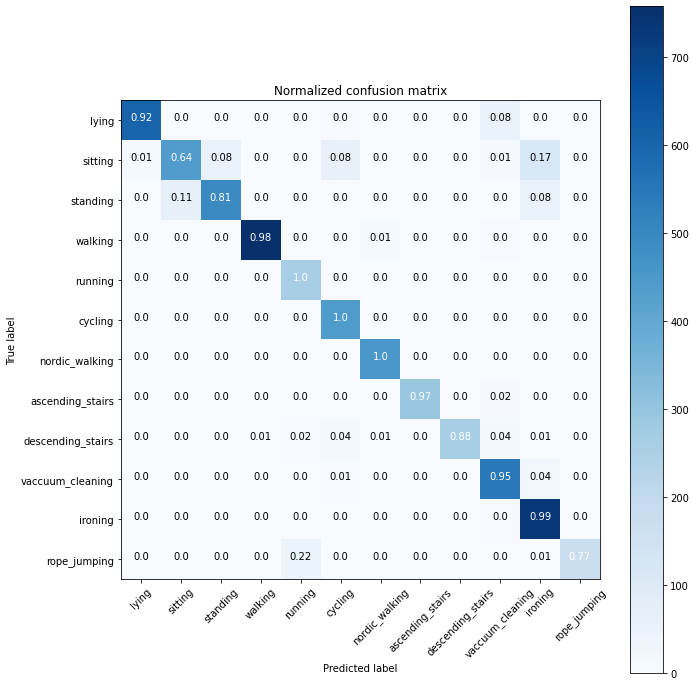

In [13]:
import tensorflow
from model_sa_tcn import Trainabble_Multiply

model = keras.models.load_model('model.12-0.91.h5',
              custom_objects={'Trainabble_Multiply':Trainabble_Multiply})

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(x_valid)
y_pred = np.argmax(y_pred, axis = 1)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def show_classification_report(y_true, y_pred, digits=4, labels=None, save_path=None):
    """
    :param y_true: 1d array containing y true
    :param y_pred: 1d array containing y pred
    :param digits: number of digits to show
    :param labels: list label names
    :param save_path: path to save report
    """

    # Select only existing labels from y true and y pred
    unique_labels = np.unique(np.array([y_true, y_pred])).astype(np.int)
    labels = labels[unique_labels]

    # show report
    report = classification_report(y_true, y_pred, digits=digits, target_names=labels)
    print(report)

    # save to file
    if save_path is not None:
        with open(save_path, 'w') as f:
            f.write(report)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = np.array(['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'nordic_walking',
 'ascending_stairs',
 'descending_stairs',
 'vaccuum_cleaning',
 'ironing',
 'rope_jumping'])
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Show classificaiton report
show_classification_report(y_true, y_pred, digits=2, labels=class_names)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize = True,
                      title='Normalized confusion matrix')

plt.show()